## Machine Learning Basics


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
# #not necessary
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


### Content List

1. knn - k nearest neighbors
2. linear regression
3. logistic regression
4. decision tree
5. random forest
6. voting classifier
7. svm - support vector machines
8. basic unsupervised shiz
9. some modelling practices
10. basic ann
11. cnn - mnist
12. cnn - gtrbr

### 1. K Nearest Neighbours

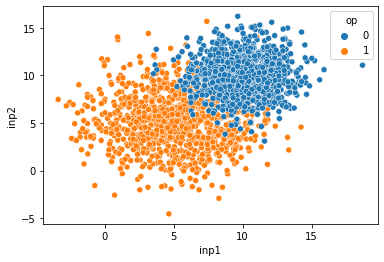

In [ ]:
#ez fake data
n_trues = 1000
n_falses = 1000
trues = np.array([np.random.normal(5,3, n_trues), np.random.normal(5,3,n_trues)])
falses = np.array([np.random.normal(10,2, n_falses), np.random.normal(10,2,n_falses)])
X = np.concatenate((trues.T, falses.T), 0)
y = np.array([1]*n_trues + [0]*n_falses)
data = pd.DataFrame({
    'inp1': X[:,0],
    'inp2': X[:,1],
    'op': y})
sb.scatterplot(data = data, x = 'inp1', y = 'inp2', hue = 'op')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors = 5)
model.fit(data[['inp1','inp2']], data['op'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

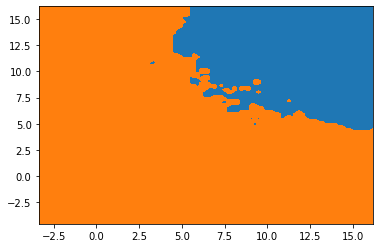

In [ ]:
#le visualization

from matplotlib.colors import ListedColormap
resolution = 100
#selecting colors from palatte
sb_cmap = ListedColormap(np.array(sb.color_palette())[:2,:]) 

#creating inputs sweeping entire plane
x, y = np.meshgrid(np.linspace(data.inp1.min(), data.inp2.max(), resolution), 
                     np.linspace(data.inp2.min(), data.inp2.max(), resolution)) 
z = model.predict(np.c_[x.ravel(),y.ravel()])
categories, z = np.unique(z, return_inverse  =True)
z = z.reshape(x.shape)
heatmap = plt.contourf(x,y,z,cmap = sb_cmap)

### 2. Linear Regression

tip = 0.1437318952772166 * bill
tip for a bill of 100 is 14


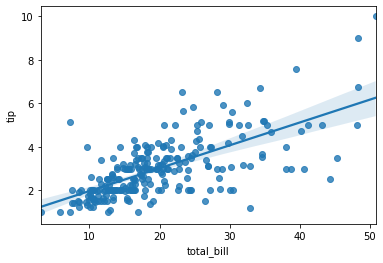

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Projects/MachineLearning/data/tips.csv')
sb.regplot(x = 'total_bill', y = 'tip', data = data) #plots and fits a linear regression

from sklearn import linear_model
line = linear_model.LinearRegression(fit_intercept = False) #in this case x =0, y=0
line.fit(np.array(data['total_bill']).reshape(-1,1), data['tip'])
print('tip =',line.coef_[0],'* bill')
bill = 100
print("tip for a bill of", bill, "is", round(line.predict([[bill]])[0]))

In [ ]:
data['predictions'] = line.predict(np.array(data.total_bill).reshape(-1,1))
data['loss'] = data.tip - data.predictions
mean_loss = data.loss.mean() #similarly you can compute other costs
mean_absolute_loss = abs(data.loss).mean()
mean_sqaured_loss = ((data.loss)**2).mean()
#OR
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(data.tip, data.predictions)

from sklearn.metrics import mean_absolute_error
MAE = mean_absolute_error(data.tip, data.predictions)

optimizing with huber loss, small epsilon --> L1 loss, larger epsilon --> L2 loss

In [ ]:
huberline = linear_model.HuberRegressor(epsilon = 1, fit_intercept = False)
huberline.fit(np.array(data.total_bill).reshape(-1,1), data.tip)

HuberRegressor(alpha=0.0001, epsilon=1, fit_intercept=False, max_iter=100,
               tol=1e-05, warm_start=False)

In [ ]:
mline = linear_model.LinearRegression(fit_intercept = False)
mline.fit(data[["total_bill", "size"]], data.tip)
mline.coef_

array([0.1007119 , 0.36209717])

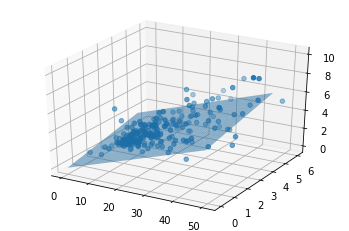

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(data["total_bill"], data["size"], data["tip"])
x, y = np.meshgrid(range(50), range(6))
coef = mline.coef_
z = coef[0]*x  + coef[1]*y
ax.plot_surface(x,y,z, alpha = 0.5)

In [ ]:
#lets add day as a feature
features = ['total_bill', 'size', 'day']
subdata = data[features]
dummiesForDay = pd.get_dummies(subdata['day']) #makes onehot type encoded df from categorical series
numericData = pd.concat([subdata, dummiesForDay], axis = 1).drop(['day'], axis = 1)

mline = linear_model.LinearRegression(fit_intercept = False)
mline.fit(numericData, data['tip'])

mean_squared_error(data['tip'], mline.predict(numericData))

1.0121298853078435

In [ ]:
#if model not fitting well, check out feature generation methods like~ polynomial features
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

poly2line = Pipeline([
                      ('poly', PolynomialFeatures(degree = 2)),
                      ('line', LinearRegression(fit_intercept=False))])#zerobillzerotip
poly2line.fit(numericData, data['tip'])
poly2line.predict(np.array([10,3,0,0,0,1]).reshape(1,-1))

array([1.9166174])

In [ ]:
#with test train split
totalData=pd.concat([numericData,data['tip']],axis=1)
traindata, valdata = np.split(totalData.sample(frac = 1), [150]) #frac 1 just means full randomized dataframe, np.split
poly2line.fit(traindata.iloc[:,:-1], traindata['tip'])
mean_squared_error(valdata['tip'], poly2line.predict(valdata.iloc[:,:-1]))

1.098960751149932

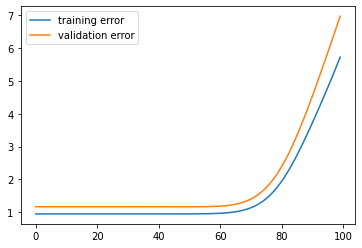

In [ ]:
#dealing with overfitting and optimizing regularization hyperparams
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

def alphaRidge(alpha, train, val):
  model = Pipeline([#considering only 2 features and their 2 degree combinations
                    ('scaler', StandardScaler()),
                    ('poly', PolynomialFeatures(degree = 2)),
                    ('ridge', Ridge(alpha = alpha, fit_intercept = False))])
  
  model.fit(train[['total_bill','size']], train['tip'])
  train_mse = mean_squared_error(train['tip'], model.predict(train[['total_bill','size']]))
  val_mse = mean_squared_error(val['tip'], model.predict(val[['total_bill','size']]))
  return train_mse, val_mse

alphas = 10**(np.linspace(-3, 3, 100))
train_errors = []
val_errors = []

for alpha in alphas:
  train_error, val_error = alphaRidge(alpha, traindata, valdata)
  train_errors.append(train_error)
  val_errors.append(val_error)

plt.plot(train_errors)
plt.plot(val_errors)
plt.legend(['training error', 'validation error'])
#this dataset isnt the best for this demo lul

In [ ]:
from sklearn.linear_model import RidgeCV
model = Pipeline([
                  ('scale', StandardScaler()),
                  ('poly', PolynomialFeatures(degree = 2)),
                  ('model', RidgeCV(alphas = 10**np.linspace(5,-5,1000), fit_intercept = False))])

model.fit(traindata[['total_bill','size']], traindata.tip)
model.named_steps['model'].alpha_ #automating everything we did above
#CV does the work

1.567455410205595

### 3. Logistic regression

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Projects/MachineLearning/data/titanic.csv')
data = data.fillna(0)
relevantLabels = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
data = data[relevantLabels]

data.Sex = data['Sex'].replace('male', 1)
data.Sex = data['Sex'].replace('female', 0)
train, val = np.split(data.sample(frac = 1), [500]) 

from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression(penalty= 'none')
logistic_model.fit(train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']], train.Survived)

from sklearn.metrics import mean_squared_error #
print('training error:', 100*mean_squared_error(train['Survived'],logistic_model.predict(train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']])),'%')
print('validation error:',100*mean_squared_error(val['Survived'],logistic_model.predict(val[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']])),'%')

training error: 19.400000000000002 %
validation error: 21.483375959079286 %


In [ ]:
# degree 2 logisitc classifier with no regularization
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

model1 = Pipeline([('scale', StandardScaler()),
                  ('poly', PolynomialFeatures(degree = 2)),
                  ('model', LogisticRegression(penalty = 'none'))])#penalty attr turned off - no regularization 
model1.fit(train[['Pclass', 'Sex', 'Age','Fare']], train['Survived'])
print(' no regularization:\n', model1.named_steps['model'].coef_)

 no regularization:
 [[-0.53139391 -1.36416712 -1.55307522 -0.41405675 -0.58311209  0.66664065
   1.57055016  0.12484556  0.32145383  0.37456664  0.39379367  0.50264997
  -0.02769049  0.12261156  0.10576725]]


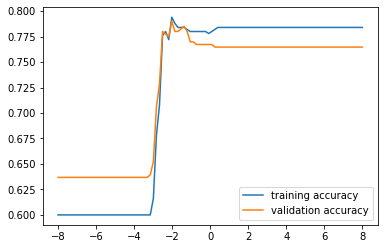

In [ ]:
#evaluation effect of regularization
def checkRegularization(C, train, val):
  model = Pipeline([('scale', StandardScaler()),
                  ('poly', PolynomialFeatures(degree = 1)),
                  #C is inverse regularization strength C=1/lambda
                  #where lambda*Weights is added to loss function to regulairze large weights - overfitting
                  ('model', LogisticRegression(C = C, max_iter = 10000))])
  
  model.fit(train[['Pclass', 'Sex', 'Age','Fare']], train['Survived'])

  train_accuracy = sum(train.Survived == model.predict(train[['Pclass', 'Sex', 'Age','Fare']]))/len(train)
  val_accuracy = sum(val.Survived == model.predict(val[['Pclass', 'Sex', 'Age','Fare']]))/len(val)
  avg_weight_size = np.mean(abs(model.named_steps['model'].coef_))

  return train_accuracy, val_accuracy, avg_weight_size

train_accuracy = []
val_accuracy = []
avg_weights = []

for c in 10**np.linspace(-8, 8, 100):
  train_acc, val_acc, weight = checkRegularization(c, train, val)
  train_accuracy.append(train_acc)
  val_accuracy.append(val_acc)
  avg_weights.append(weight)

plt.plot(np.linspace(-8,8,100), train_accuracy)
plt.plot(np.linspace(-8,8,100), val_accuracy)
plt.legend(['training accuracy', 'validation accuracy'])

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
model = Pipeline([('scale', StandardScaler()),
                  ('poly', PolynomialFeatures(degree = 2)),
                  ('model', LogisticRegressionCV(Cs = 10**np.linspace(8,-8,100), cv = 5))])
model.fit(data[['Pclass', 'Sex', 'Age','Fare']], data['Survived'])
model.named_steps['model'].C_[0]

0.08902150854450357

### 4. Decision Tree

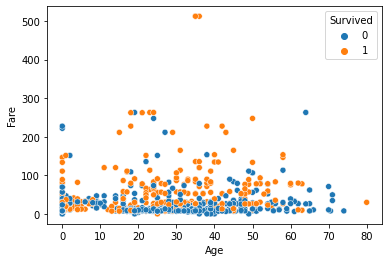

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Projects/MachineLearning/data/titanic.csv')
data = data.fillna(0)
relevantLabels = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
data = data[relevantLabels]

data.Sex = data['Sex'].replace('male', 1)
data.Sex = data['Sex'].replace('female', 0)
train, val = np.split(data.sample(frac = 1), [500])

sb.scatterplot(data = data, x = 'Age', y = 'Fare', hue = 'Survived')

In [ ]:
from sklearn import tree
tree_model = tree.DecisionTreeClassifier()
tree_model = tree_model.fit(data[['Fare', 'Age']], data['Survived'])
tree_model.predict(data.sample(10)[['Fare', 'Age']])

array([0, 0, 1, 0, 0, 1, 1, 1, 0, 1])

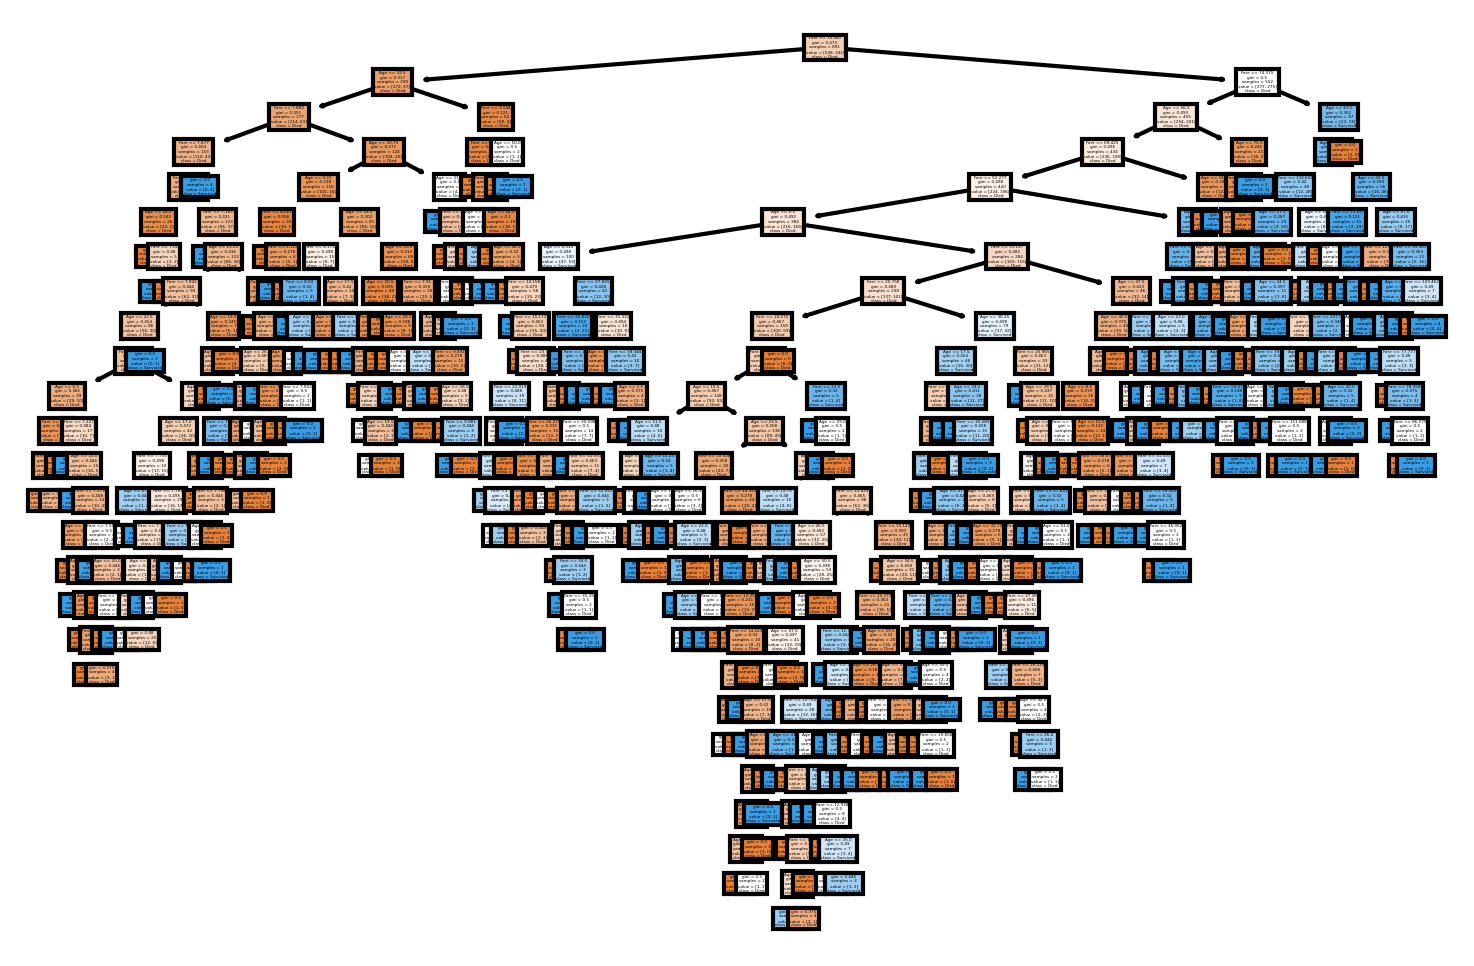

In [ ]:
#visualising tree
import matplotlib as mpl
mpl.rcParams['text.color'] = 'black'
fig, ax = plt.subplots(nrows = 1, ncols = 1, dpi=300)
tree.plot_tree(
    tree_model,
    feature_names = ['Fare','Age'],
    class_names = ['Died','Survived'],
    filled = True
)
plt.show()

In [ ]:
#visualising classifier like a 
def heatmap(model):
  from matplotlib.colors import ListedColormap
  sb_cmap = ListedColormap(np.array(sb.color_palette())[0:2,:])
  x , y  = np.meshgrid(np.arange(0,100,1), np.arange(0,500,5))
  z = model.predict(np.c_[x.ravel(), y.ravel()])
  categories,z = np.unique(z, return_inverse=True)
  z = z.reshape(x.shape)
  boundary_map = plt.contourf(x, y, z, cmap = sb_cmap)
  sb.scatterplot(data=data, x='Age', y='Fare', hue='Survived')
  plt.show()

Decision tree score 94.94949494949495 %


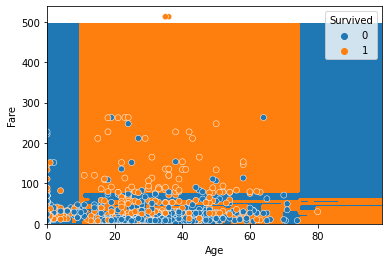

In [ ]:
from sklearn.metrics import accuracy_score
# just for visualization, not accurate score as only training errors accounted
print('Decision tree score', 100*accuracy_score(tree_model.predict(data[['Fare','Age']]),data['Survived']),'%')
heatmap(tree_model)

Decision tree score 66.89113355780022 %


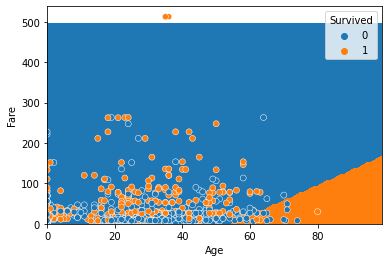

In [ ]:
#just to compare to a differentiable ml model
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression(penalty = 'none')
logistic_model.fit(data[["Fare", "Age"]], data['Survived'])
print('Decision tree score', 100*accuracy_score(logistic_model.predict(data[['Fare','Age']]),data['Survived']),'%')
heatmap(logistic_model)

### 5. Random Forest Classifier

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Projects/MachineLearning/data/titanic.csv')
data = data.fillna(0)
relevantLabels = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
data = data[relevantLabels]

data.Sex = data['Sex'].replace('male', 1)
data.Sex = data['Sex'].replace('female', 0)
train, val = np.split(data.sample(frac = 1), [500])

In [ ]:
data.sample(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
135,0,2,1,23.0,0,0,15.0458
129,0,3,1,45.0,0,0,6.9750
787,0,3,1,8.0,4,1,29.1250
49,0,3,0,18.0,1,0,17.8000
210,0,3,1,24.0,0,0,7.0500


Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
dtype: int64